# ECCO HEAT BUDGET - revised

### 13-tile native lat-lon-cap 90 grid
The lat-lon-cap (llc) is the decomposition of the spherical Earth into a Cartesian curvilinear coordinate system . It is a topologically non-trivial cubed-sphere rendering in the northern hemisphere and a dipolar grid in the southern hemisphere. Between 70°S and ~57°N, model grid cells are approximately oriented to lines of latitude and longitude. A special Arctic “cap” is situated north of ~57°N.

The Cartesian curvilinear coordinate system is divided into 13 tiles, each consisting of 90x90 grid cells in the horizontal and 50 vertical levels. Horizontal model grid resolution varies spatially from 22km to 110km, with the highest resolutions at high latitudes and lowest resolution in mid latitudes. Vertical grid spacing increases with depth from 10m to 456.5m. The bottom of the deepest model grid cell is 6145m below the surface.
https://ecco-v4-python-tutorial.readthedocs.io/fields.html

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.99:42969")
client

Client Scheduler: tcp://10.32.5.99:42969 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline

In [3]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [4]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.a

In [5]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
#rename time (and iter axis)
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
#dt.time.values = ds.time.values[1:-1] 
#add nans to dt to change size form 286 to 288

ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

#should I just add nans as first and last value?

In [6]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 26

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2727: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


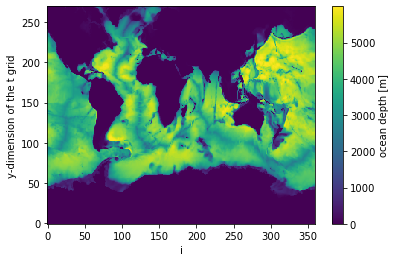

In [7]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=100).drop('i').plot()

In [8]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [9]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90

In [10]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90

In [11]:
dt.time

<xarray.DataArray 'time' (time: 286)>
array(['1992-02-13T00:00:00.000000000', '1992-03-15T00:00:00.000000000',
       '1992-04-14T00:00:00.000000000', ..., '2015-09-14T00:00:00.000000000',
       '2015-10-15T00:00:00.000000000', '2015-11-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter_snp  (time) int64 1428 2172 2892 3636 ... 207444 208164 208908 209628
  * time      (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Attributes:
    axis:               T
    c_grid_axis_shift:  0.5
    long_name:          Time
    standard_name:      time

In [12]:
ds.time_snp

<xarray.DataArray 'time_snp' (time_snp: 287)>
array(['1992-02-01T00:00:00.000000000', '1992-03-01T00:00:00.000000000',
       '1992-04-01T00:00:00.000000000', ..., '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Attributes:
    axis:               T
    c_grid_axis_shift:  0.5
    long_name:          Time
    standard_name:      time

In [13]:
coords

<xarray.Dataset>
Dimensions:   (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    PHrefC    (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    drF       (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    YC        (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    YG        (j_g, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    hFacS     (k, j_g, i) float32 dask.array<chunksize=(50, 90, 90), meta=np.ndarray>
    iter_snp  (time) float64 nan 1.428e+03 2.172e+03 ... 2.089e+05 2.096e+05 nan
    rAw       (j, i_g)

In [14]:
ds#.assign_coords(dt=dt)

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90

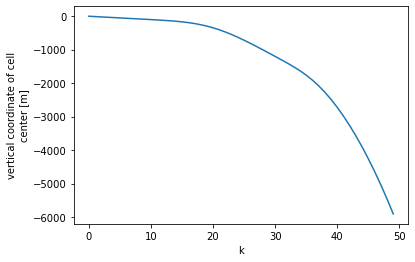

In [15]:
coords.Z.plot()
#bins stretch vertically as you go down

In [16]:
coords.Z.isel(k=36).values
#Z interior @ ~2km --> k=36

array(-1914.15, dtype=float32)

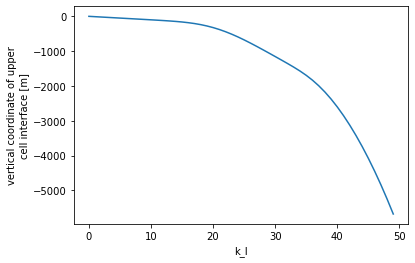

In [17]:
coords.Zl.plot()

In [18]:
coords.Z.isel(k=slice(36,50)).values

array([-1914.15 , -2084.035, -2276.225, -2491.25 , -2729.25 , -2990.25 ,
       -3274.25 , -3581.25 , -3911.25 , -4264.25 , -4640.25 , -5039.25 ,
       -5461.25 , -5906.25 ], dtype=float32)

In [19]:
coords.Zl.isel(k_l=slice(36,50)).values

array([-1834.68, -1993.62, -2174.45, -2378.  , -2604.5 , -2854.  ,
       -3126.5 , -3422.  , -3740.5 , -4082.  , -4446.5 , -4834.  ,
       -5244.5 , -5678.  ], dtype=float32)

In [20]:
coords.Zl.isel(k_l=37).values

array(-1993.62, dtype=float32)

## Heat budget for WG (entire water column)

In [21]:
sst_mean = ds.THETA.isel(k=0).mean(dim='time').load()

In [22]:
surface_mask = (coords.hFacC[0]>0).load()
surface_mask

<xarray.DataArray 'hFacC' (j: 270, i: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: j, i

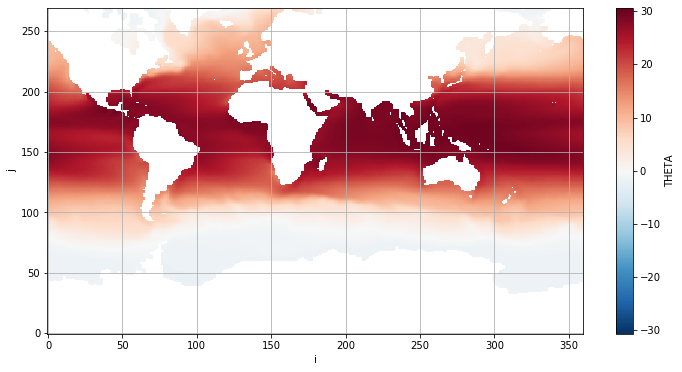

In [23]:
sst_mean.where(surface_mask).plot(figsize=(12,6))
plt.grid();

In [24]:
sst_mean_wg = sst_mean.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg = surface_mask.sel(i=slice(75, 167), j=slice(35, 75))

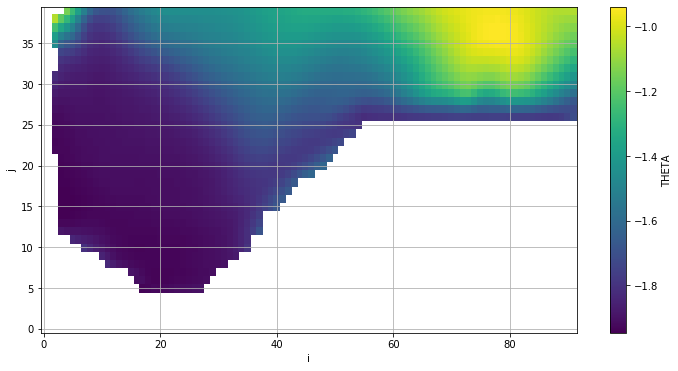

In [25]:
sst_mean_wg.where(surface_mask_wg).plot(figsize=(12,6))
plt.grid();

In [26]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

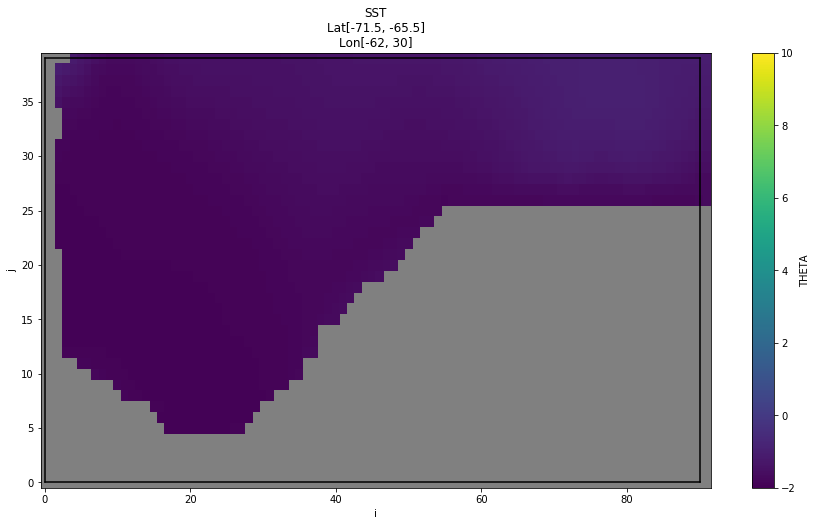

In [27]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg.where(surface_mask_wg).plot(ax=ax,  vmin=-2, vmax=10)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [28]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [29]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [30]:
ds.ADVx_TH

<xarray.DataArray 'ADVx_TH' (time: 288, k: 50, j: 270, i_g: 360)>
dask.array<rechunk-merge, shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: k, j, i_g
Attributes:
    long_name:      Zonal      Advective Flux of Pot.Temperature
    mate:           ADVy_TH
    standard_name:  ADVx_TH
    units:          degC.m^3/s

In [31]:
#advective flux
adv_flux_y = ds.ADVy_TH.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_TH.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([-10279822. , -12982561. , -12934308. , -11529351. , -13233150. ,
       -13227701. , -16918540. , -17533964. , -12029000. , -13338824. ,
       -11684683. , -10107401. ,  -9936628. ,  -8369260. ,  -8628236. ,
       -10462839. , -14309224. , -12153286. , -11164441. , -13248400. ,
       -13284907. , -11809472. , -10799110. ,  -9224446. , -10348053. ,
       -11711611. , -10524329. , -15556556. , -12643217. , -15685256. ,
       -18548768. , -16268600. , -17606960. , -11912290. , -12132664. ,
       -11315942. ,  -9672219. , -10832539. , -11272650. , -12330596. ,
       -14881999. , -12203364. , -11968709. , -14111922. , -13319475. ,
       -11791479. ,  -9388406. ,  -9919769. ,  -9631786. , -10642762. ,
        -9850282. , -11024318. , -16911508. , -15154511. , -15413208. ,
       -12206237. , -15878690. , -13557608. ,  -9864835. ,  -9541725. ,
       -10347162. ,  -9929631. ,  -7728644.5, -12077234. , -14220682. ,
       -13985020. , -13412908. , 

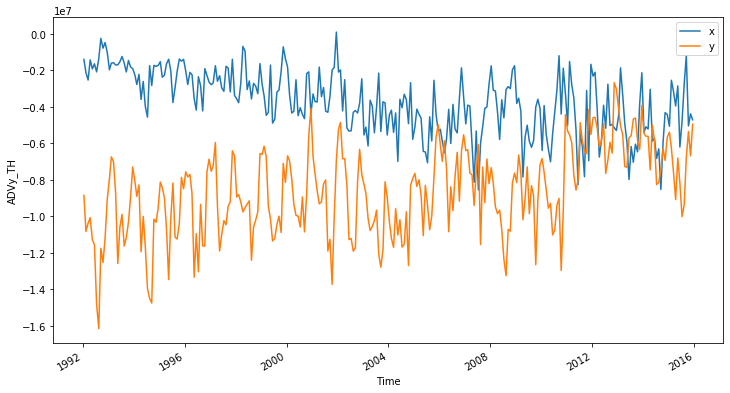

In [32]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [33]:
#diffusive flux
diff_flux_y = ds.DFyE_TH.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_TH.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([1178107.1  , 1184438.6  ,  886113.06 ,  547791.25 ,  483972.   ,
        658329.3  ,  753108.06 ,  698095.44 ,  674622.3  ,  592480.1  ,
        663303.25 ,  689142.56 ,  617473.8  ,  764413.5  ,  698005.94 ,
        433855.3  ,  426203.44 ,  474118.25 ,  574022.75 ,  531614.94 ,
        529918.06 ,  523984.66 ,  579642.56 ,  619499.25 ,  717179.5  ,
        800407.25 ,  677434.6  ,  328629.2  ,  238002.45 ,  300506.7  ,
        249870.31 ,  304772.44 ,  362253.7  ,  322803.7  ,  387256.03 ,
        373933.53 ,  570727.75 ,  617700.   ,  435240.5  ,   56634.766,
         78839.45 ,  196444.12 ,  164831.61 ,   35393.047,   10656.344,
         47084.54 ,  194928.81 ,  379860.94 ,  557531.25 ,  716714.75 ,
        574408.56 ,  172562.84 ,   44132.46 ,  215988.7  ,  251711.6  ,
        135926.72 ,  108967.   ,   96685.03 ,  292387.22 ,  440827.6  ,
        727387.5  ,  786399.9  ,  603858.3  ,  270647.3  ,   33845.45 ,
         81560.234,   28120.48 , 

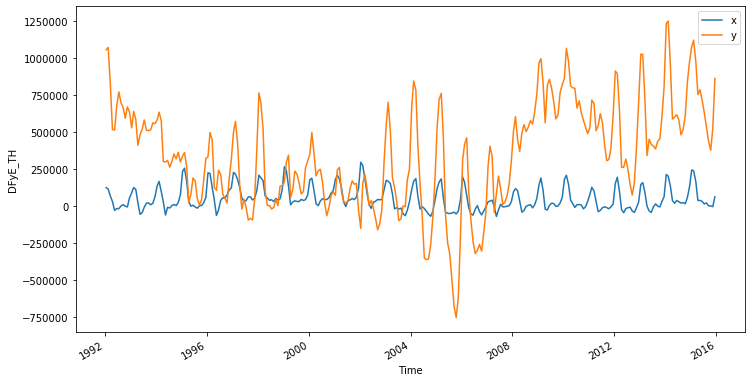

In [34]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

In [35]:
ds.TFLUX

<xarray.DataArray 'TFLUX' (time: 288, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(288, 270, 360), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [36]:
coords.rA

<xarray.DataArray 'rA' (j: 270, i: 360)>
dask.array<rechunk-merge, shape=(270, 360), dtype=float32, chunksize=(90, 90), chunktype=numpy.ndarray>
Dimensions without coordinates: j, i
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [37]:
#vertical flux
t_flux_z = (ds.TFLUX * coords.rA * coords.hFacC.isel(k=0)).isel(**lat_range, **lon_range).sum(dim=['i','j'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 288)>
array([ 1.43034474e+14,  3.47586502e+13, -1.31015721e+14, -1.43389178e+14,
       -1.00552894e+14, -8.35964801e+13, -7.40822467e+13, -7.51679759e+13,
       -6.99549132e+13, -4.74316349e+13,  6.13709513e+11,  7.44695739e+13,
        1.31689620e+14,  3.85949326e+13, -8.37327950e+13, -1.31484535e+14,
       -9.27042854e+13, -6.87630388e+13, -6.26031455e+13, -6.53847702e+13,
       -6.60551751e+13, -4.70838306e+13, -1.14971514e+13,  6.69595887e+13,
        1.29815672e+14,  5.51681251e+13, -9.42196623e+13, -1.24113960e+14,
       -1.10858122e+14, -9.26805205e+13, -7.06615653e+13, -8.50197584e+13,
       -6.60353151e+13, -5.18084876e+13, -1.01599737e+13,  6.89441153e+13,
        1.28149912e+14,  5.37826500e+13, -9.16163752e+13, -1.34001923e+14,
       -9.42889270e+13, -6.85540744e+13, -6.09187382e+13, -5.60376169e+13,
       -6.47869896e+13, -5.17945415e+13, -2.27388571e+13,  4.22826989e+13,
        1.38030191e+14,  8.37661565e+13, -7.31938428e+13, -1.63185219

In [38]:
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)

surface_term.load()

#ECCO has nonlinear surface so don't wry about 'lin_fs_correction' term
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([ 34601292. ,   8408422. , -31693850. , -34687096. , -24324626. ,
       -20222720. , -17921144. , -18183792. , -16922706. , -11474128. ,
          148461.7,  18014842. ,  31856872. ,   9336452. , -20255696. ,
       -31807260. , -22425978. , -16634381. , -15144249. , -15817148. ,
       -15979325. , -11389991. ,  -2781261.5,  16198111. ,  31403548. ,
        13345653. , -22792562. , -30024254. , -26817550. , -22420230. ,
       -17093652. , -20567024. , -15974521. , -12532927. ,  -2457786.5,
        16678185. ,  31000586. ,  13010494. , -22162804. , -32416238. ,
       -22809318. , -16583831. , -14736776. , -13555990. , -15672540. ,
       -12529553. ,  -5500728.5,  10228555. ,  33390712. ,  20263766. ,
       -17706232. , -39475932. , -24812024. , -16897182. , -15955900. ,
       -18627428. , -16754882. , -10101338. ,  -1167003.8,  20962236. ,
        41153668. ,  11566654. , -21324138. , -40671990. , -33489296. ,
       -24067902. , -17739868. , 

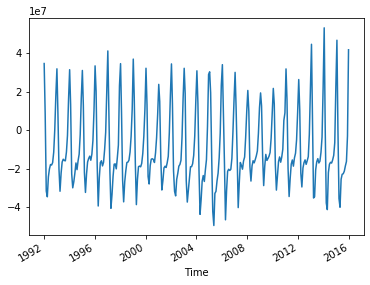

In [39]:
surface_term.plot(label='surf')

In [40]:
ds.ETAN_snp.values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [41]:
theta_scaled = (ds.THETA_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
theta_scaled

<xarray.DataArray (time_snp: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: k, j, i

In [46]:
#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
theta_scaled = xr.DataArray(theta_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data
#                                     , 'k': theta_scaled['theta_scaled.k.dims'].data, 
#                                                      'j': theta_scaled['theta_scaled.j.dims'].data, 
#                                                      'i': theta_scaled['theta_scaled.i.dims'].data
                                   })
theta_scaled

<xarray.DataArray 'sub-47faef79116268cb029e13373e23fcac' (time: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [47]:
theta_tend = (theta_scaled / coords.dt[1:287])

In [48]:
tottend_weddell = (theta_tend * coords.rA * coords.drF * coords.hFacC).isel(**lat_range, **lon_range
                                                                           ).sum(dim=['i', 'j', 'k']
                                                                                ).load()

In [ ]:
adv_flux

In [ ]:
diff_flux

In [ ]:
surface_term

In [ ]:
tottend_weddell

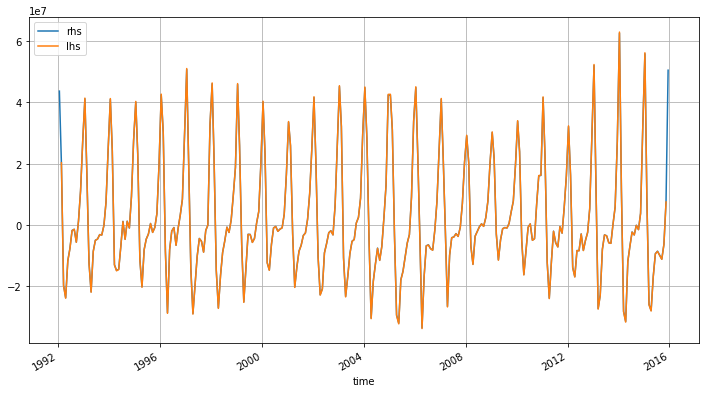

In [49]:
plt.figure(figsize=(12,6))
rhs = -adv_flux - diff_flux + surface_term
lhs = tottend_weddell
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

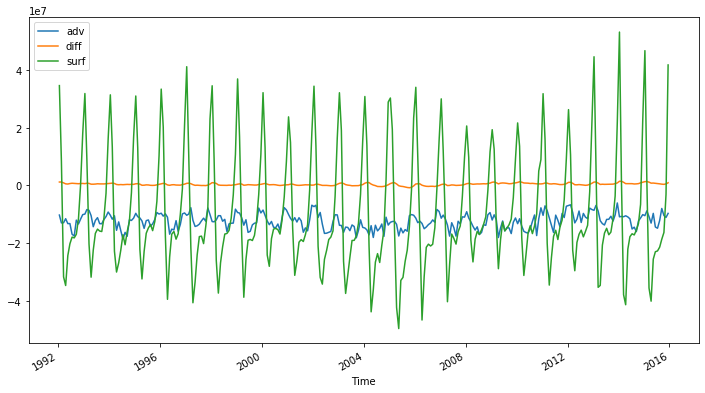

In [50]:
plt.figure(figsize=(12,6))
adv_flux.plot(label='adv')
diff_flux.plot(label='diff')
surface_term.plot(label='surf')
plt.legend()

## Heat budget for Lower WG (-2,046m to bottom)

In [51]:
coords.Z.isel(k=36).values

array(-1914.15, dtype=float32)

In [52]:
sst_mean_lower = ds.THETA.isel(k=36).mean(dim='time').load()

In [53]:
surface_mask_lower = (coords.hFacC.isel(k=36)>0).load()

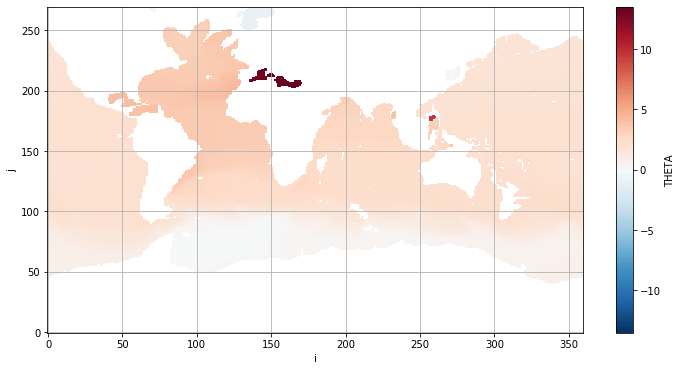

In [54]:
sst_mean_lower.where(surface_mask_lower).plot(figsize=(12,6))
plt.grid();

In [55]:
sst_mean_wg_lower = sst_mean_lower.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg_lower = surface_mask_lower.sel(i=slice(75, 167), j=slice(35, 75))

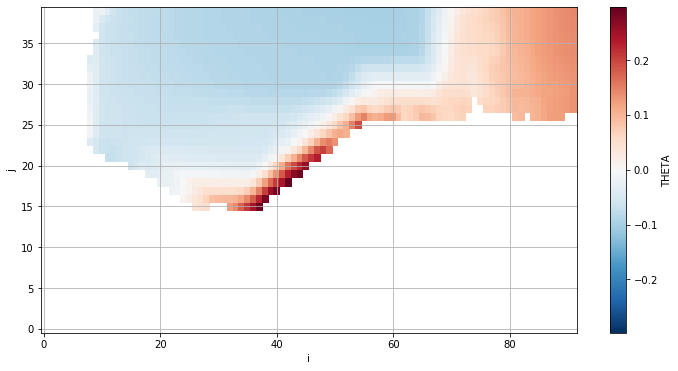

In [56]:
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(figsize=(12,6))
plt.grid();

In [57]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

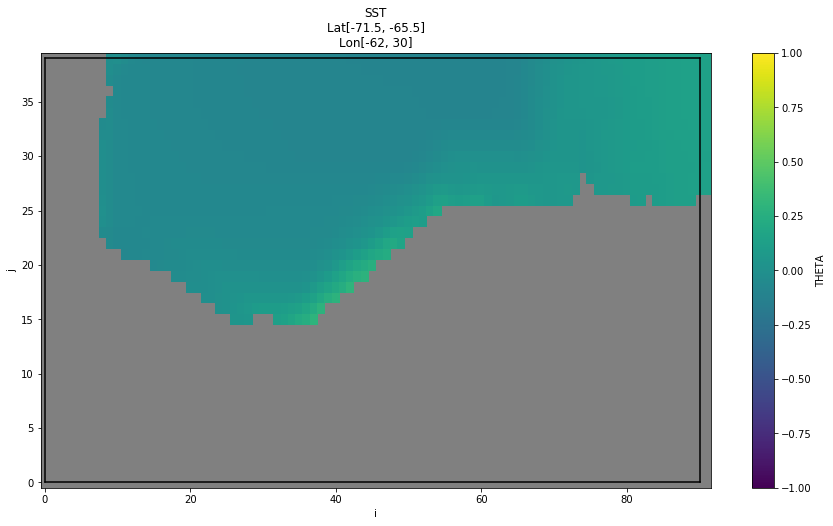

In [58]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(ax=ax,  vmin=-1, vmax=1)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [59]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167


lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [60]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [61]:
#advective flux
adv_flux_y_lower = ds.ADVy_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
adv_flux_x_lower = ds.ADVx_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
adv_flux_z_lower = ds.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([-5.22148875e+05, -1.37863925e+06, -7.73351500e+05, -4.13085500e+05,
       -2.30887550e+06, -2.98221550e+06, -1.89213350e+06, -1.67236825e+06,
       -8.95417812e+04, -4.11769812e+05,  6.46511500e+05, -9.79401562e+05,
       -2.11089550e+06, -8.37470875e+05, -9.12925625e+05, -1.19821075e+06,
       -8.61151188e+05, -1.09752712e+06, -1.69873719e+05, -9.87580250e+05,
       -1.40006312e+06,  2.56836156e+05, -9.00550188e+05, -1.29334800e+06,
       -1.14253762e+06, -1.48316800e+06, -4.94404125e+05, -2.05509350e+06,
       -1.79438462e+06, -3.44151900e+06, -3.59223450e+06, -1.77197391e+05,
       -1.34935938e+06, -1.12965875e+06, -1.43327425e+06, -6.01705000e+05,
       -3.54835844e+05, -3.49309750e+05, -6.43073625e+05, -3.69568531e+05,
       -1.11469075e+06, -5.40205125e+05, -3.20880725e+06, -8.92341875e+05,
       -8.76573188e+05,  1.94922812e+05,  5.83546406e+04,  7.76434062e+05,
       -5.52600562e+05, -3.29631969e+05,  2.16091312e+05, -8.64053750

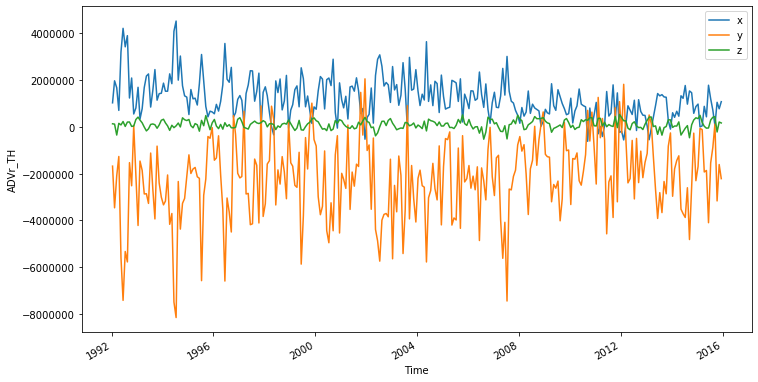

In [62]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [63]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
diff_flux_x_lower = ds.DFxE_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
diff_flux_z_lower = ((ds.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                    + ds.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([243964.03  , 217606.33  , 202374.28  , 192274.08  , 232227.53  ,
       291486.2   , 372205.47  , 416333.34  , 400257.38  , 367774.38  ,
       321882.88  , 285788.2   , 257877.53  , 232121.44  , 214171.75  ,
       199123.6   , 201046.    , 169967.02  , 190148.66  , 222906.06  ,
       237019.11  , 235988.8   , 213936.47  , 189200.22  , 168097.5   ,
       154403.22  , 148352.88  , 137310.03  , 144500.33  , 186441.84  ,
       200594.31  , 223882.69  , 215316.84  , 194199.4   , 169666.53  ,
       140583.27  , 117980.516 , 101042.73  ,  94485.47  ,  85586.88  ,
       105861.83  ,  95280.34  ,  97013.9   , 114060.31  , 103631.914 ,
        88418.05  ,  87452.82  ,  77479.984 ,  57535.027 ,  54729.64  ,
        43682.273 ,  36254.977 ,  64390.293 , 105407.97  , 166882.64  ,
       170712.62  , 154634.72  , 135994.72  , 136792.2   , 117095.3   ,
        80579.45  ,  66169.05  ,  55130.57  ,  46368.023 ,  80229.37  ,
       103084.47  , 139601.1   , 

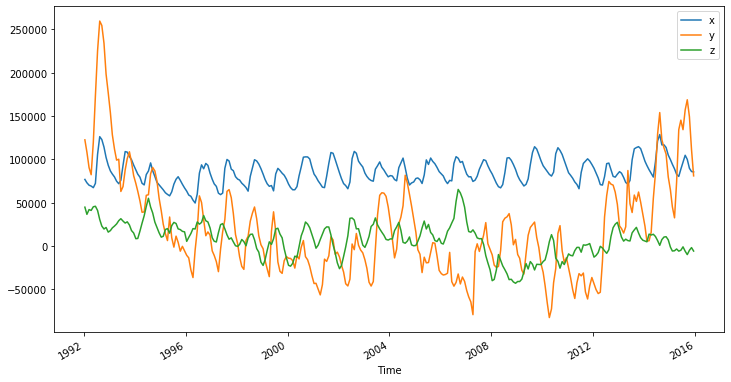

In [64]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [65]:
tottend_weddell_lower = (theta_tend * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['i', 'j','k'])
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 286)>
array([ 1.20629868e+06,  6.16240007e+05,  2.66077268e+05,  2.12191159e+06,
        2.73599464e+06,  1.56519285e+06,  1.30129909e+06, -2.65450485e+05,
        8.92601889e+04, -9.23129337e+05,  7.38877507e+05,  1.89828247e+06,
        6.50614461e+05,  7.44017901e+05,  1.04435168e+06,  7.05369327e+05,
        9.72825690e+05,  2.49896347e+04,  8.09938780e+05,  1.20830840e+06,
       -4.47560244e+05,  7.31877893e+05,  1.14941251e+06,  1.01970431e+06,
        1.37403064e+06,  3.91314079e+05,  1.96304862e+06,  1.69514876e+06,
        3.30034263e+06,  3.43690557e+06, -1.42118918e+03,  1.17930598e+06,
        9.80724174e+05,  1.30887291e+06,  5.06386886e+05,  2.82119582e+05,
        2.93531286e+05,  5.93852902e+05,  3.29246301e+05,  1.05409289e+06,
        4.90189039e+05,  3.15705823e+06,  8.23545850e+05,  8.18206439e+05,
       -2.38076332e+05, -1.00542637e+05, -8.08649689e+05,  5.40330055e+05,
        3.20167236e+05, -2.14508249e+05,  8.73062365e+05,  1.79020008

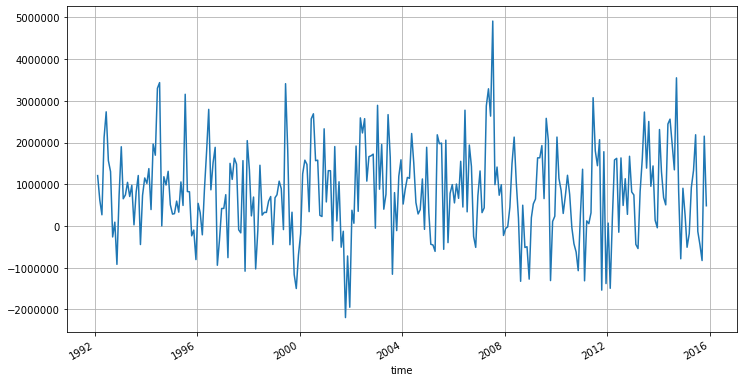

In [66]:
tottend_weddell_lower.plot(figsize=(12,6))
plt.grid()

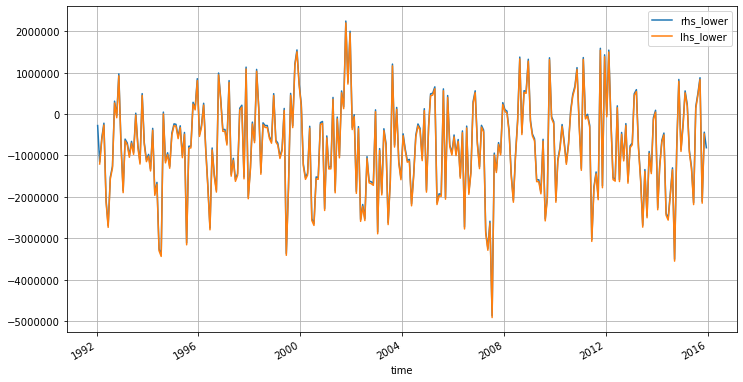

In [67]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower = - tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();
#plt.savefig('SOSE-heat-inter-rhs-lhs-timeseries', format='pdf')